In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Load the data
data = pd.read_csv('data/share-of-global-habitable-land-needed-for-agriculture-if-everyone-had-the-diet-of.csv')

# Load a shapefile of the world
world = gpd.read_file('image/ne_10m_admin_0_countries.shp')




In [2]:
name_mapping = {
    'United States of America': 'United States',
    'Republic of the Congo': 'Congo',
    'United Republic of Tanzania': 'Tanzania',  # Updated
    'The Bahamas': 'Bahamas',
    'Republic of Serbia': 'Serbia',
    'Tazania': 'Tanzania',  # New
    'Ivory Coast': "Cote d'Ivoire",  # New
    # Add more mappings here as needed
}

# Replace the old names with the new ones in the 'SOVEREIGNT' column
world['SOVEREIGNT'] = world['SOVEREIGNT'].replace(name_mapping)

# Strip leading/trailing spaces from country names
world['SOVEREIGNT'] = world['SOVEREIGNT'].str.strip()
data['Entity'] = data['Entity'].str.strip()


In [3]:
# Separate 'World' data from the rest
world_data = data[data['Entity'] == 'World']
other_data = data[data['Entity'] != 'World']


In [4]:
missing_countries = ['South Sudan', 'Somalia', 'Syria', 'Somaliland', 'Western Sahara',
                     'Democratic Republic of the Congo', 'Bhutan', 'Kosovo', 'Libya', 
                     'Sudan', 'Eritrea', 'Liechtenstein', 'Qatar', 'San Marino', 
                     'Monaco', 'eSwatini', 'Burundi', 'Andorra', 'Brazilian Island', 
                     'Papua New Guinea', 'Equatorial Guinea', 'Vatican', 'Northern Cyprus', 
                     'Cyprus No Mans Area', 'Kashmir', 'Southern Patagonian Ice Field', 
                     'Bir Tawil', 'Antarctica', 'Taiwan', 'Seychelles', 'Marshall Islands', 
                     'Comoros', 'São Tomé and Principe', 'Singapore', 'Tonga', 'Tuvalu', 
                     'Nauru', 'Federated States of Micronesia', 'Palau', 'Bahrain', 
                     'Spratly Islands', 'Bajo Nuevo Bank (Petrel Is.)', 'Serranilla Bank', 
                     'Scarborough Reef']

# Create a new DataFrame for the missing countries
missing_df = pd.DataFrame(missing_countries, columns=['Entity'])

# Set the 'HALF Index (habitable land area) (Alexander et al. (2016))' column to NaN
missing_df['HALF Index (habitable land area) (Alexander et al. (2016))'] = np.nan

# Concatenate the original DataFrame with the new DataFrame
data = pd.concat([data, missing_df], ignore_index=True)




In [5]:
# Now you can merge the dataframes
merged = world.merge(data, how='left', left_on='SOVEREIGNT', right_on='Entity')



In [6]:
# Add the world data back in if needed
world = pd.concat([merged, world_data])


In [7]:
# Get the world average
world_avg = world_data['HALF Index (habitable land area) (Alexander et al. (2016))'].values[0]

world_avg




49.5

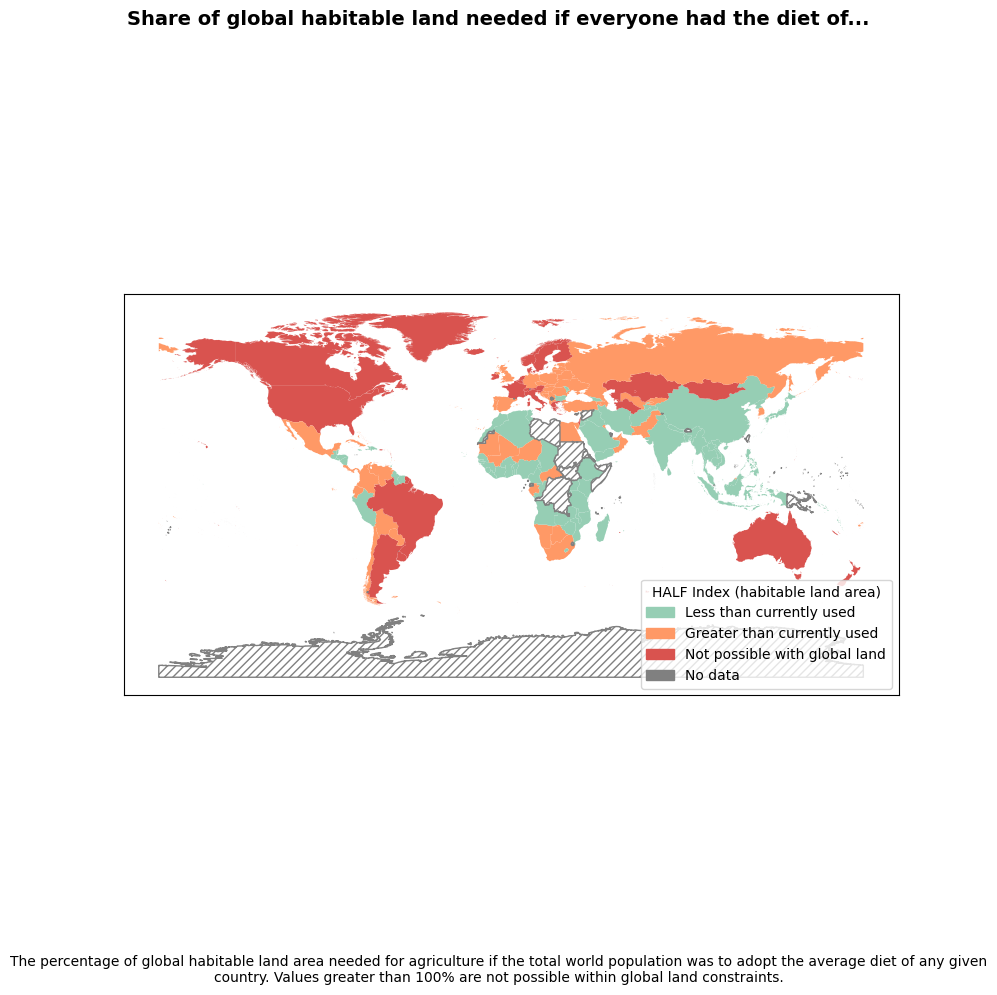

In [21]:
# Create a new column 'color' based on the condition
world['color'] = np.where(world['HALF Index (habitable land area) (Alexander et al. (2016))'].isnull(), 'no_data', 
                          np.where(world['HALF Index (habitable land area) (Alexander et al. (2016))'] < world_avg, 'blue', 
                          np.where(world['HALF Index (habitable land area) (Alexander et al. (2016))'] <= 99, 'yellow', 'red')))

# Create a custom color map
color_dict = {'blue': '#96ceb4', 'yellow': '#ff9966', 'red': '#d9534f', 'no_data': '#7f7f7f'}

# Create a new color column with actual colors
world['color_mapped'] = world['color'].map(color_dict)

# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Add the title and the description
plt.suptitle("Share of global habitable land needed if everyone had the diet of...", fontsize=14, fontweight='bold')


# Plot the non-"No data" areas first
world[world['color'] != 'no_data'].geometry.plot(facecolor=world[world['color'] != 'no_data']['color_mapped'], ax=ax)

# Then plot the "No data" areas with a hatch pattern
world[world['color'] == 'no_data'].geometry.plot(facecolor='none', edgecolor='grey', hatch='////', ax=ax)

# Create a custom legend
legend_labels = {
    '#96ceb4': 'Less than currently used',
    '#ff9966': 'Greater than currently used',
    '#d9534f': 'Not possible with global land',
    'grey': 'No data'
}
# Add an additional handle for the hatched pattern
handles = [mpatches.Patch(color=color, label=label, hatch='////' if color == 'grey' else None) for color, label in legend_labels.items()]
plt.legend(handles, legend_labels.values(), title='HALF Index (habitable land area)', loc='lower right')


# Remove x and y axis marks
ax.set_xticks([])
ax.set_yticks([])

# Add the description at the bottom
plt.figtext(0.5, 0.01, "The percentage of global habitable land area needed for agriculture if the total world population was to adopt the average diet of any given country. Values greater than 100% are not possible within global land constraints.", ha="center", fontsize=10, wrap=True)

plt.show()

